<img src="https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Attribution.png" width="400">

<h1 align="left">Multi-investment Attribution: Distinguish the Effects of Multiple Outreach Efforts</h1>

A startup that sells software would like to know whether its multiple outreach efforts were successful in attracting new customers or boosting consumption among existing customers. They would also like to distinguish the effects of several incentives on different kinds of customers. In other words, they would like to learn the **heterogeneous treatment effect** of each investment on customers' software usage. 

In an ideal world, the startup would run several randomized experiments where each customer would receive a random assortment of investments. However, this can be logistically prohibitive or strategically unsound: the startup might not have the resources to design such experiments or they might not want to risk losing out on big opportunities due to lack of incentives.

In this customer scenario walkthrough, we show how tools from the [EconML](https://aka.ms/econml) library can use historical investment data to learn the effects of multiple investments.

### Summary

1. [Background](#Background)
2. [Data](#Data)
3. [Get Causal Effects with EconML](#Get-Causal-Effects-with-EconML)
4. [Understand Treatment Effects with EconML](#Understand-Treatment-Effects-with-EconML)
5. [Make Policy Decisions with EconML](#Make-Policy-Decisions-with-EconML)
6. [Conclusions](#Conclusions)

# Background

<img src="https://get.pxhere.com/photo/update-software-upgrade-laptop-computer-install-program-screen-system-repair-data-development-electronic-load-pc-process-progress-support-technical-load-1565823.jpg" width="400">

In this scenario, a startup that sells software provides two types of incentives to its customers: technical support and discounts. A customer might be given one, both or none of these incentives. 

The startup has historical data on these two investments for 2,000 customers, as well as how much revenue these customers generated in the year after the investments were made. They would like to use this data to learn the optimal incentive policy for each existing or new customer in order to maximize the return on investment (ROI).

The startup faces two challenges: 1) the dataset is biased because historically the larger customers received the most incentives and 2) the observed outcome combines effects from two different investments. Thus, they need a causal model that can accommodate multiple concurrent interventions. 

**Solution:** EconML’s `Doubly Robust Learner` model jointly estimates the effects of multiple discrete treatments. The model uses flexible functions of observed customer features to filter out spurious correlations in existing data and deliver the causal effect of each intervention on revenue.


In [121]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')
# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd

# Generic ML imports
from xgboost import XGBRegressor, XGBClassifier

# EconML imports
from econml.dr import LinearDRLearner

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data

The data* contains ~2,000 customers and is comprised of:

* Customer features: details about the industry, size, revenue, and technology profile of each customer.
* Interventions: information about which incentive was given to a customer.
* Outcome: the amount of product the customer bought in the year after the incentives were given.

Feature Name | Type | Details 
:--- |:--- |:--- 
**Global Flag** | W | whether the customer has global offices
**Major Flag** | W | whether the customer is a large consumer in their industry (as opposed to SMC - Small Medium Corporation - or SMB - Small Medium Business)
**SMC Flag** | W | whether the customer is a Small Medium Corporation (SMC, as opposed to major and SMB)
**Commercial Flag** | W | whether the customer's business is commercial (as opposed to public secor)
**IT Spend** | W | \\$ spent on IT-related purchases 
**Employee Count** | W | number of employees
**PC Count** | W | number of PCs used by the customer
**Size** | X | customer's size given by their yearly total revenue 
**Tech Support** | T | whether the customer received tech support (binary)
**Discount** | T | whether the customer was given a discount (binary)
**Revenue** | Y | \\$ Revenue from customer given by the amount of software purchased

**To protect the privacy of the startup's customers, the data used in this scenario is synthetically generated and the feature distributions don't correspond to real distributions. However, the feature names have preserved their names and meaning.*

In [122]:
# Import the sample multi-attribution data
file_url = "https://msalicedatapublic.blob.core.windows.net/datasets/ROI/multi_attribution_sample.csv"
multi_data = pd.read_csv(file_url)

In [123]:
# Data sample
multi_data.head()

,Global Flag,Major Flag,SMC Flag,Commercial Flag,IT Spend,Employee Count,PC Count,Size,Tech Support,Discount,Revenue
0,1,0,1,0,45537,26,26,152205,0,1,17688.36300
1,0,0,1,1,20842,107,70,159038,0,1,14981.43559
2,0,0,0,1,82171,10,7,264935,1,1,32917.13894
3,0,0,0,0,30288,40,39,77522,1,1,14773.76855
4,0,0,1,0,25930,37,43,91446,1,1,17098.69823


In [336]:
# Define estimator inputs
T_bin = multi_data[
    ["Tech Support", "Discount"]
]  # multiple interventions, or treatments
Y = multi_data["Revenue"]  # amount of product purchased, or outcome
X = multi_data[["Size"]]  # heterogeneity feature
W = multi_data.drop(
    columns=["Tech Support", "Discount", "Revenue", "Size"]
)  # controls

We investigate below whether the number of investments given is correlated with the size of the customer. We note that the average customer size is larger for more incentives given. 

In [337]:
# Average customer size per incentive combination
multi_data[["Size", "Tech Support", "Discount"]].groupby(
    by=["Tech Support", "Discount"], as_index=False
).mean().astype(int)

,Tech Support,Discount,Size
0,0,0,70943
1,0,1,96466
2,1,0,108978
3,1,1,171466


The data was generated using the following underlying treatment effect function:

$$
\text{treatment_effect(Size)} = (5,000 + 2\% \cdot \text{Size}) \cdot I_\text{Tech Support} + (5\% \cdot \text{Size}) \cdot I_\text{Discount}
$$

Therefore, the treatment effect depends on the customer's size as follows: tech support provides an consumption boost of \$5,000 + 2\% Size and a discount provides an consumption boost of 5\% Size.**This is the relationship we seek to learn from the data.**

In [339]:
# Define underlying treatment effect function
TE_fn = lambda X: np.hstack([5000 + 2 / 100 * X, 5 / 100 * X])
true_TE = TE_fn(X)

# Define true coefficients for the three treatments
# The third coefficient is just the sum of the first two since we assume an additive effect
true_coefs = [2 / 100, 5 / 100, 7 / 100]
true_intercepts = [5000, 0, 5000]
treatment_names = ["Tech Support", "Discount", "Tech Support & Discount"]

# Get Causal Effects with EconML

To get causal effects, we use EconML's `LinearDRLearner`* estimator. This estimator requires a set of discrete treatments $T$ that corresponds to different types of interventions. Thus, we first map the binary interventions tech support and discount into one categorical variable:

Tech support| Discount| Treatment encoding| Details
:--- |:--- |:--- |:---
0 | 0 | 0 | no incentive
1 | 0 | 1 | tech support only
0 | 1 | 2 | discount only
1 | 1 | 3 | both incentives

The estimator takes as input the outcome of interest $Y$ (amount of product purchased), a discrete treatment $T$ (interventions given), heterogeneity features $X$ (here, customer's size) and controls $W$ (all other customer features).


The LinearDRLearner also requires two auxiliary models to model the relationships $T\sim (W, X)$ (`model_propensity`) and $Y \sim (W, X)$(`model_regression`). These can be generic, flexible classification and regression models, respectively.  


**This estimator assumes a linear relationship between the treatment effect and a transformation of the features $X$ (e.g. a polynomial basis expansion). For more generic forms of the treatment effect, see the `DRLearner` estimator.*

In [340]:
# Transform T to one-dimensional array with consecutive integer encoding
def treat_map(t):
    return np.dot(t, 2 ** np.arange(t.shape[0]))


T = np.apply_along_axis(treat_map, 1, T_bin).astype(int)

In [341]:
# Train EconML model with generic helper models
model = LinearDRLearner(
    model_regression=XGBRegressor(learning_rate=0.1, max_depth=3),
    model_propensity=XGBClassifier(learning_rate=0.1, max_depth=3, objective="multi:softmax"),
    random_state=1,
)
# Specify final stage inference type and fit model
model.fit(Y=Y, T=T, X=X, W=W, inference="statsmodels")

# Understand Treatment Effects with EconML

We can obtain a summary of the coefficient values as well as confidence intervals by calling the `summary` function on the fitted model for each treatment.

In [342]:
for i in range(model._d_t[0]):
    print(f"Investment: {treatment_names[i]}")
    print(f"True treatment effect: {true_intercepts[i]} + {true_coefs[i]}*Size")
    display(model.summary(T=i + 1))

Investment: Tech Support
True treatment effect: 5000 + 0.02*Size


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
Size,0.021,0.012,1.749,0.08,0.001,0.04
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,5326.61,845.551,6.3,0.0,3935.802,6717.419


Investment: Discount
True treatment effect: 0 + 0.05*Size


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
Size,0.052,0.012,4.371,0.0,0.032,0.071
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,358.698,848.771,0.423,0.673,-1037.406,1754.802


Investment: Tech Support & Discount
True treatment effect: 5000 + 0.07*Size


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
Size,0.074,0.012,6.292,0.0,0.054,0.093
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,4899.208,851.54,5.753,0.0,3498.549,6299.867


From the summary panels, we see that the learned coefficients/intercepts are close to the true coefficients/intercepts and the p-values are small for most of these. 

We further use the `coef_, coef__interval` and the `intercept_, intercept__interval` methods to obtain the learned coefficient values and build confidence intervals. We compare the true and the learned coefficients through the plots below.

In [343]:
# Compare learned coefficients with true model coefficients
# Aggregate data
coef_indices = np.arange(model._d_t[0])
coefs = np.hstack([model.coef_(T=i) for i in 1 + coef_indices])
intercepts = np.hstack([model.intercept_(T=i) for i in 1 + coef_indices])

# Calculate coefficient error bars for 90% confidence interval
coef_error = np.hstack([model.coef__interval(T=i) for i in 1 + coef_indices])
coef_error[0, :] = coefs - coef_error[0, :]
coef_error[1, :] = coef_error[1, :] - coefs

# Calculate intercept error bars for 90% confidence interval
intercept_error = np.vstack(
    [model.intercept__interval(T=i) for i in 1 + coef_indices]
).T
intercept_error[0, :] = intercepts - intercept_error[0, :]
intercept_error[1, :] = intercept_error[1, :] - intercepts

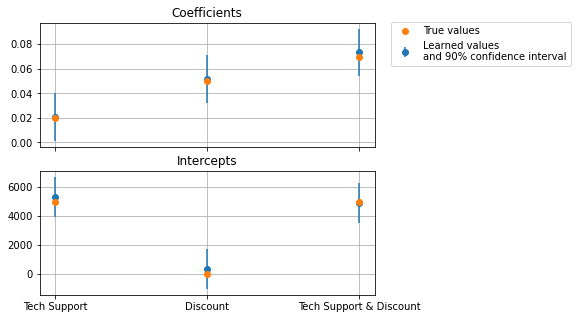

In [345]:
# Plot coefficients
plt.figure(figsize=(6, 5))
ax1 = plt.subplot(2, 1, 1)
plt.errorbar(
    coef_indices,
    coefs,
    coef_error,
    fmt="o",
    label="Learned values\nand 90% confidence interval",
)
plt.scatter(coef_indices, true_coefs, color="C1", label="True values", zorder=3)
plt.xticks(coef_indices, treatment_names)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.title("Coefficients")
plt.legend(loc=(1.05, 0.65))
plt.grid()

# Plot intercepts
plt.subplot(2, 1, 2)
plt.errorbar(coef_indices, intercepts, intercept_error, fmt="o")
plt.scatter(coef_indices, true_intercepts, color="C1", zorder=3)
plt.xticks(coef_indices, treatment_names)
plt.title("Intercepts")
plt.grid()
plt.show()

# Make Policy Decisions with EconML

Investments such as tech support and discounts come with an associated cost. Thus, we would like to know what incentives to give to each customer to maximize the profit from their increased engagement. This is the **treatment policy**.

In this scenario, we define a cost function as follows:
* The cost of `tech support` scales with the number of PCs a customer has. You can imagine that if the software product needs tech support to be installed on each machine, there is a cost (\\$100 here) per machine.
* The cost of `discount` is a fixed \\$7,000. Think of this as giving the customer the first \\$7,000 worth of product for free.
* The cost of `tech support` and `discount` is the sum of the cost of each of these. Note that this might not be the case in every business application: it is possible that managing multiple incentive programs can add overhead. 

In [346]:
# Define cost function
def cost_fn(multi_data):
    t1_cost = multi_data[["PC Count"]].values * 100
    t2_cost = np.ones((multi_data.shape[0], 1)) * 7000
    return np.hstack([t1_cost, t2_cost, t1_cost + t2_cost])

We use the model's `const_marginal_effect` method to find the counterfactual treatment effect for each possible treatment. We then subtract the treatment cost and choose the treatment which the highest return. That is the recommended policy.

In [347]:
# Get roi for each customer and possible treatment
potential_roi = model.const_marginal_effect(X=X.values) - cost_fn(multi_data)
# Add a column of 0s for no treatment
potential_roi = np.hstack([np.zeros((X.shape[0], 1)), potential_roi])

In [348]:
all_treatments = np.array(["None"] + treatment_names)
recommended_T = np.argmax(potential_roi, axis=1)

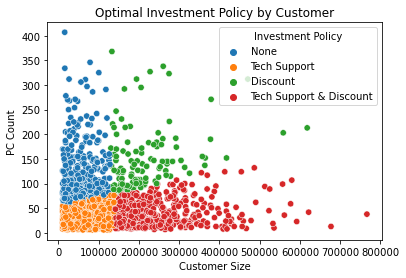

In [349]:
ax1 = sns.scatterplot(
    x=X.iloc[:, 0].values.flatten(),
    y=multi_data["PC Count"].values,
    hue=all_treatments[recommended_T],
    hue_order=all_treatments,
    cmap="Dark2",
    s=40,
)
plt.legend(title="Investment Policy")
plt.setp(
    ax1,
    xlabel="Customer Size",
    ylabel="PC Count",
    title="Optimal Investment Policy by Customer",
)
plt.show()

We compare different policies: the optimal policy we learned, the current policy, and the policy under which each customer is given all incentives. We note that the optimal policy has a much higher ROI than the alternatives. 

In [350]:
roi_current = potential_roi[np.arange(X.shape[0]), T].sum()
roi_optimal = potential_roi[np.arange(X.shape[0]), recommended_T].sum()
roi_bothT = potential_roi[:, -1].sum()
all_rois = np.array([roi_optimal, roi_current, roi_bothT])
Y_baseline = (Y - model.effect(X=X.values, T1=T)).sum()

In [351]:
pd.DataFrame(
    {
        "Policy": ["Optimal", "Current", "All Investments"],
        "ROI ($)": all_rois,
        "ROI (% of baseline Y)": np.round(all_rois / Y_baseline * 100, 1),
    }
)

,Policy,ROI ($),ROI (% of baseline Y)
0,Optimal,9.735967e+06,64.0
1,Current,2.535077e+06,16.7
2,All Investments,9.683798e+05,6.4


### Performance of policies based on ground truth

In [352]:
true_roi = np.zeros((X.shape[0], 4))
true_roi[:, 1:3] = TE_fn(X.iloc[:, [0]])
true_roi[:, 3] = np.sum(true_roi[:, 1:3], axis=1)
true_roi[:, 1:] -= cost_fn(multi_data)

In [353]:
roi_current = true_roi[np.arange(X.shape[0]), T].sum()
roi_optimal = true_roi[np.arange(X.shape[0]), recommended_T].sum()
roi_bothT = true_roi[:, -1].sum()
all_rois = np.array([roi_optimal, roi_current, roi_bothT])
Y_baseline = (Y - model.effect(X=X.values, T1=T)).sum()

In [354]:
pd.DataFrame(
    {
        "Policy": ["Optimal", "Current", "All Investments"],
        "ROI ($)": all_rois,
        "ROI (% of baseline Y)": np.round(all_rois / Y_baseline * 100, 1),
    }
)

,Policy,ROI ($),ROI (% of baseline Y)
0,Optimal,8920500.30,58.6
1,Current,1829938.41,12.0
2,All Investments,373176.80,2.5


# Policy Decisions Using Doubly Robust Policy Learning

In [356]:
from econml.policy import DRPolicyForest

X = multi_data[['Size', 'PC Count']]
est = DRPolicyForest(random_state=1,
                     min_propensity=1e-1,
                     min_impurity_decrease=0.1,
                     min_samples_leaf=50,
                     max_depth=4)
costs = np.hstack([np.zeros((X.shape[0], 1)), cost_fn(multi_data)])
est.fit(Y - costs[np.arange(X.shape[0]), T], T, X=X)
recommended_T = est.predict(X)

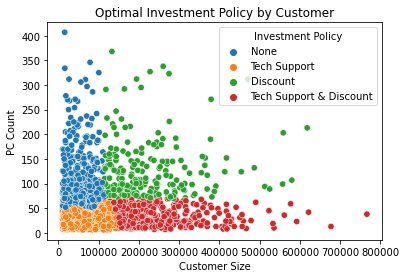

In [357]:
ax1 = sns.scatterplot(
    x=X.iloc[:, 0].values.flatten(),
    y=multi_data["PC Count"].values,
    hue=all_treatments[recommended_T],
    hue_order=all_treatments,
    cmap="Dark2",
    s=40,
)
plt.legend(title="Investment Policy")
plt.setp(
    ax1,
    xlabel="Customer Size",
    ylabel="PC Count",
    title="Optimal Investment Policy by Customer",
)
plt.show()

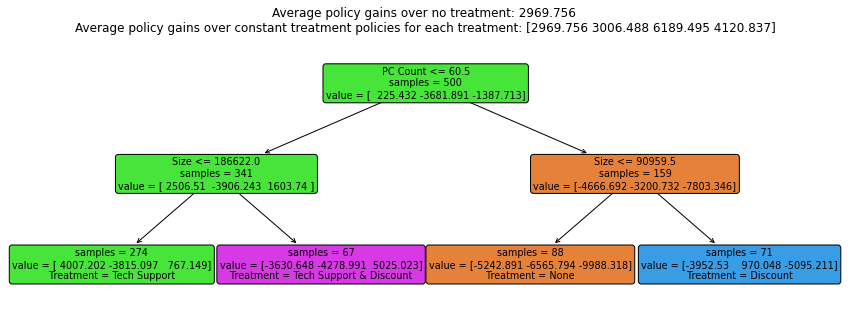

In [363]:
plt.figure(figsize=(15, 5))
est.plot(0, treatment_names=['None'] + treatment_names)

### Performance based on ground truth

In [361]:
roi_current = true_roi[np.arange(X.shape[0]), T].sum()
roi_optimal = true_roi[np.arange(X.shape[0]), recommended_T].sum()
roi_bothT = true_roi[:, -1].sum()
all_rois = np.array([roi_optimal, roi_current, roi_bothT])
Y_baseline = (Y - model.effect(X=X.values[:, [0]], T1=T)).sum()

In [362]:
pd.DataFrame(
    {
        "Policy": ["Optimal", "Current", "All Investments"],
        "ROI ($)": all_rois,
        "ROI (% of baseline Y)": np.round(all_rois / Y_baseline * 100, 1),
    }
)

,Policy,ROI ($),ROI (% of baseline Y)
0,Optimal,8703724.97,57.2
1,Current,1829938.41,12.0
2,All Investments,373176.80,2.5


# Conclusions

In this notebook, we have demonstrated the power of using EconML to:

* Learn the effects of multiple concurrent interventions
* Interpret the resulting individual-level treatment effects
* Build investment policies around the learned effects

To learn more about what EconML can do for you, visit our [website](https://aka.ms/econml), our [GitHub page](https://github.com/microsoft/EconML) or our [documentation](https://econml.azurewebsites.net/). 